In [1]:
pip install pandas numpy nltk tensorflow scikit-learn lime matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 13.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=b86fd509fbcede9ed94472c53e81118920f0ab5977196db8f6fb50546ad6f8ac
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [2]:
import pandas as pd
import re
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, Bidirectional, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk
from lime import lime_text
from lime.lime_text import LimeTextExplainer
import matplotlib.pyplot as plt

In [3]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
#training and test data
train_data = pd.read_csv('/content/train.csv')
test_data = pd.read_csv('/content/test.csv')

In [5]:
# Remove null and duplicate values from training data
train_data.dropna(subset=['crimeaditionalinfo'], inplace=True)
train_data.drop_duplicates(inplace=True)

In [6]:
# Remove null and duplicate values from test data
test_data.dropna(subset=['crimeaditionalinfo'], inplace=True)
test_data.drop_duplicates(inplace=True)

In [7]:
# Define text cleaning and preprocessing functions
def clean_text(text):
    text = text.lower()  # Lowercase text
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    return text

In [8]:
def preprocess_text(text):
    tokens = text.split()
    tokens = [token for token in tokens if token not in stop_words]
    tokens = [stemmer.stem(token) for token in tokens]
    return ' '.join(tokens)

In [9]:
# Apply text cleaning and preprocessing to train and test data
train_data['cleaned_text'] = train_data['crimeaditionalinfo'].apply(clean_text)
train_data['processed_text'] = train_data['cleaned_text'].apply(preprocess_text)
test_data['cleaned_text'] = test_data['crimeaditionalinfo'].apply(clean_text)
test_data['processed_text'] = test_data['cleaned_text'].apply(preprocess_text)

In [10]:
# Prepare data for the neural network
X_train = train_data['processed_text']
y_train = train_data['category']
X_test = test_data['processed_text']
y_test = test_data['category']

In [11]:
all_labels = pd.concat([y_train, y_test]).unique()
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Encode train and test labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Compute class weights to handle class imbalance in y_train
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights_dict = dict(enumerate(class_weights))


In [12]:
# Tokenization
tokenizer = Tokenizer(num_words=7000)  # Adjusted vocabulary size
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [13]:
# Padding sequences
max_length = 100  # Fixed length for efficiency
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length)

In [14]:
# Build the neural network model
model = Sequential()
model.add(Embedding(input_dim=7000, output_dim=200, input_length=max_length))
model.add(SpatialDropout1D(0.3))
model.add(Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3)))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [15]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [16]:
# Train the model
history = model.fit(
    X_train_pad, y_train_encoded,
    epochs=20,
    batch_size=64,
    class_weight=class_weights_dict,
    verbose=2
)

Epoch 1/20
1342/1342 - 1095s - 816ms/step - accuracy: 0.4793 - loss: 42.2270
Epoch 2/20
1342/1342 - 1080s - 805ms/step - accuracy: 0.5701 - loss: 30.3507
Epoch 3/20
1342/1342 - 1100s - 820ms/step - accuracy: 0.5994 - loss: 24.6000
Epoch 4/20
1342/1342 - 1095s - 816ms/step - accuracy: 0.6208 - loss: 20.7358
Epoch 5/20
1342/1342 - 1072s - 799ms/step - accuracy: 0.6325 - loss: 18.3702
Epoch 6/20
1342/1342 - 1099s - 819ms/step - accuracy: 0.6413 - loss: 16.6234
Epoch 7/20
1342/1342 - 1110s - 827ms/step - accuracy: 0.6491 - loss: 16.4195
Epoch 8/20
1342/1342 - 1100s - 820ms/step - accuracy: 0.6559 - loss: 15.4270
Epoch 9/20
1342/1342 - 1101s - 821ms/step - accuracy: 0.6641 - loss: 13.4460
Epoch 10/20
1342/1342 - 1100s - 819ms/step - accuracy: 0.6691 - loss: 13.2522
Epoch 11/20
1342/1342 - 1084s - 808ms/step - accuracy: 0.6729 - loss: 12.7314
Epoch 12/20
1342/1342 - 1089s - 811ms/step - accuracy: 0.6770 - loss: 12.1665
Epoch 13/20
1342/1342 - 1146s - 854ms/step - accuracy: 0.6808 - loss: 12.

In [17]:
# Predict on test data
y_pred_probs = model.predict(X_test_pad)
y_pred = np.argmax(y_pred_probs, axis=1)

909/909 ━━━━━━━━━━━━━━━━━━━━ 160s 176ms/step


In [18]:
# Classification report
report = classification_report(
    y_test_encoded,
    y_pred,
    target_names=label_encoder.classes_,  # Use the classes from the training set
    labels=np.unique(y_train_encoded),  # Ensure we use only the classes from training
    output_dict=True
)

print("Classification Report:")
print(classification_report(
    y_test_encoded,
    y_pred,
    target_names=label_encoder.classes_,
    labels=np.unique(y_train_encoded),  # Fixing the class mismatch
))

# Convert classification report to DataFrame for plotting
report_df = pd.DataFrame(report).transpose()

Classification Report:
                                                      precision    recall  f1-score   support

                               Any Other Cyber Crime       0.00      0.00      0.00      3662
Child Pornography CPChild Sexual Abuse Material CSAM       0.00      0.00      0.00       119
                      Crime Against Women & Children       0.00      0.00      0.00       164
                                Cryptocurrency Crime       1.00      1.00      1.00      1261
                      Cyber Attack/ Dependent Crimes       0.00      0.00      0.00        52
                                     Cyber Terrorism       0.36      0.15      0.21       592
      Hacking  Damage to computercomputer system etc       0.00      0.00      0.00        61
                            Online Cyber Trafficking       0.83      0.87      0.85     17618
                              Online Financial Fraud       0.00      0.00      0.00       134
                            Online G

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2642: UserWarning: labels size, 15, does not match size of target_names, 16
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_d

<Figure size 1000x600 with 0 Axes>

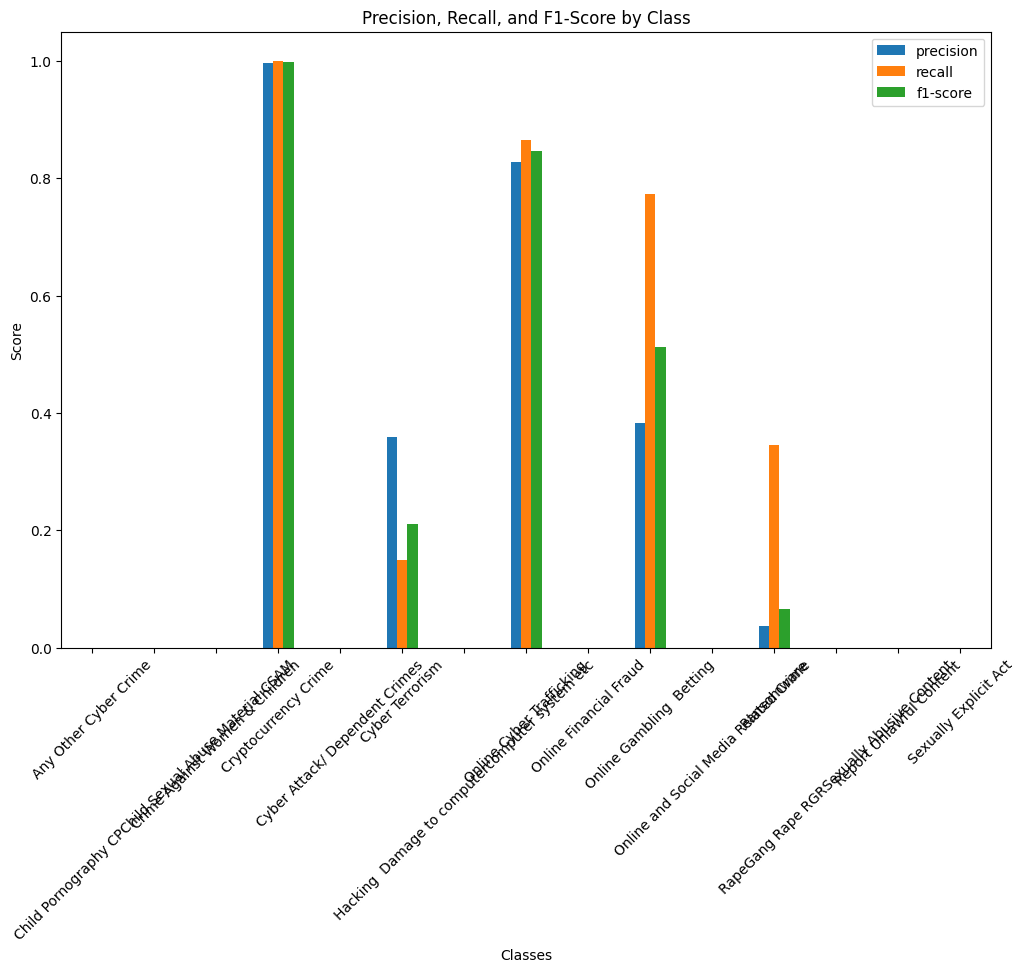

In [19]:
# Plot accuracy, precision, recall, and F1-score
plt.figure(figsize=(10, 6))
metrics = ['precision', 'recall', 'f1-score']
report_df[metrics][:-3].plot(kind='bar', figsize=(12, 8))
plt.title('Precision, Recall, and F1-Score by Class')
plt.xlabel('Classes')
plt.ylabel('Score')
plt.legend(loc="upper right")
plt.xticks(rotation=45)
plt.show()

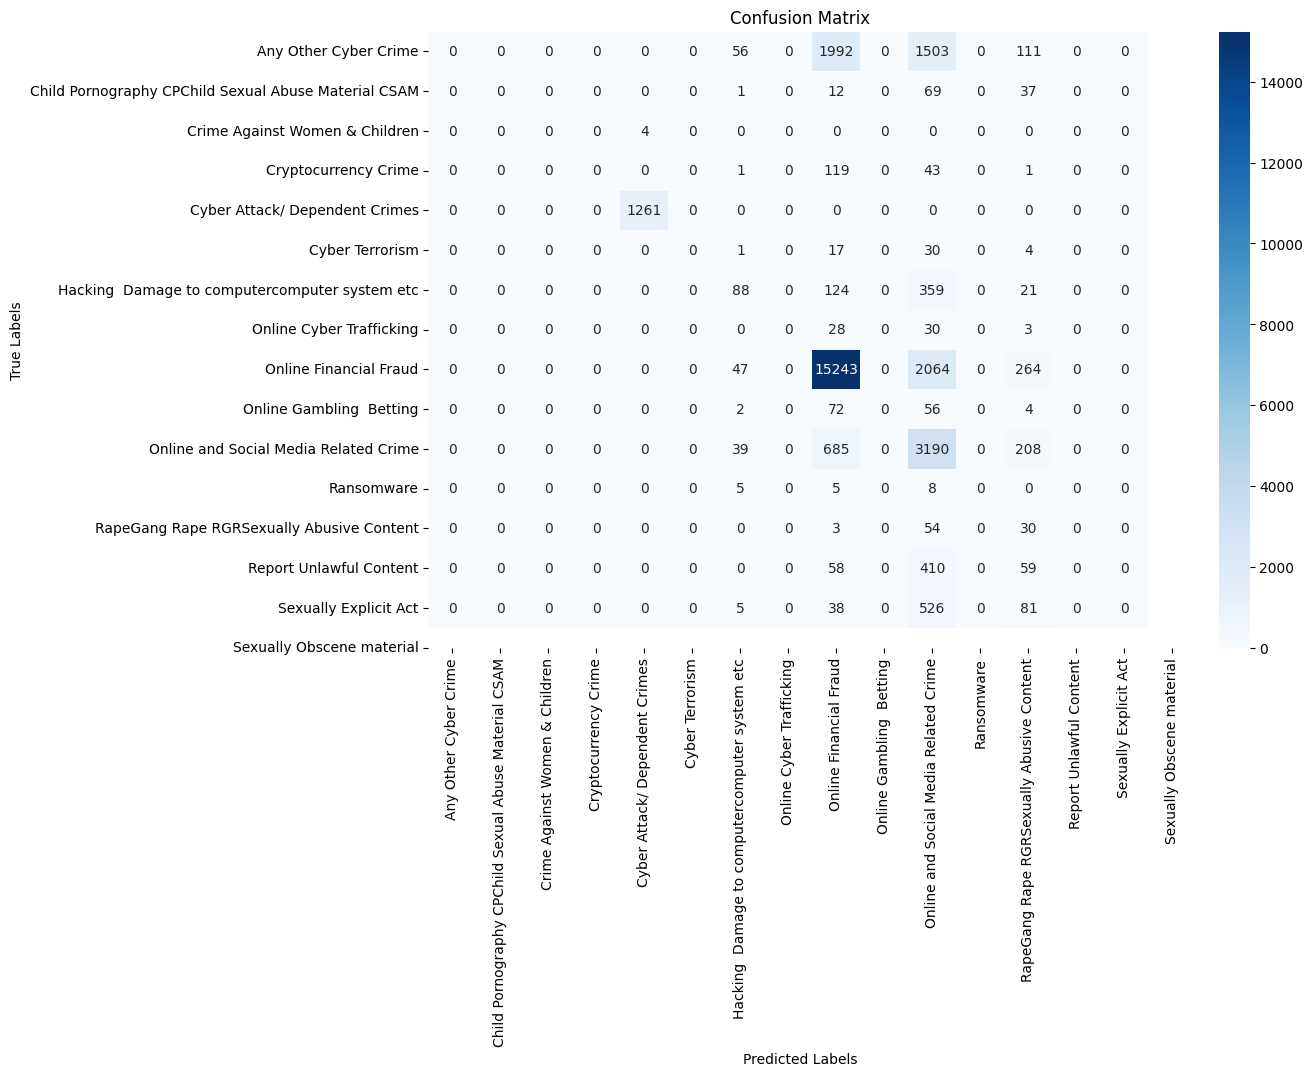

In [20]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Plot confusion matrix
cm = confusion_matrix(y_test_encoded, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

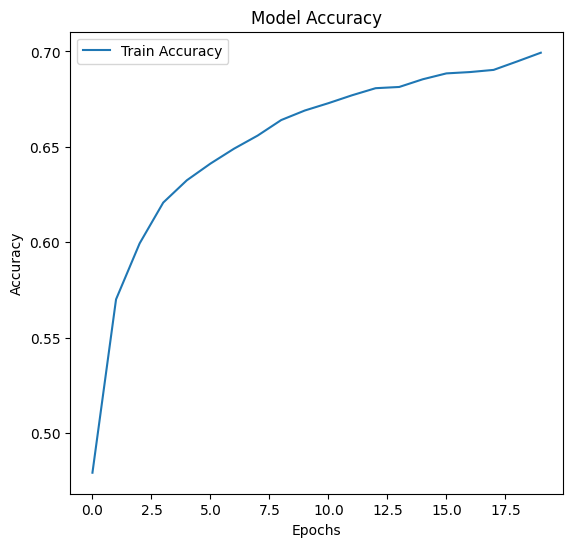

In [21]:
# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

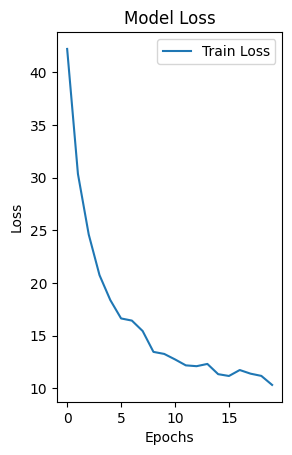

In [22]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [27]:
!pip install reportlab

In [28]:
from lime.lime_text import LimeTextExplainer
import numpy as np
import matplotlib.pyplot as plt
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib import colors
from io import BytesIO
from PIL import Image
import tempfile
import os

def predict_category_with_explanation_pdf(user_input):
    cleaned_input = clean_text(user_input)
    processed_input = preprocess_text(cleaned_input)
    input_seq = tokenizer.texts_to_sequences([processed_input])
    input_pad = pad_sequences(input_seq, maxlen=max_length)

    # Prediction
    prediction = model.predict(input_pad)
    predicted_category_index = np.argmax(prediction, axis=1)[0]
    predicted_category = label_encoder.inverse_transform([predicted_category_index])[0]

    # LIME explanation
    explainer = LimeTextExplainer(class_names=label_encoder.classes_)
    explanation = explainer.explain_instance(
        processed_input,
        classifier_fn=lambda x: model.predict(pad_sequences(tokenizer.texts_to_sequences(x), maxlen=max_length)),
        num_features=10
    )

    # Save explanation
    fig = explanation.as_pyplot_figure()
    plt.title(f"Top Words Influencing Prediction for '{predicted_category}'")
    temp_img_path = tempfile.mktemp(suffix=".png")
    fig.savefig(temp_img_path, format='PNG')
    plt.close(fig)

    # Create PDF
    pdf_path = "/content/prediction_explanation.pdf"
    c = canvas.Canvas(pdf_path, pagesize=A4)
    width, height = A4

    # Add header
    c.setFont("Helvetica-Bold", 16)
    c.drawString(50, height - 50, "Prediction Results")

    # Add prediction category
    c.setFont("Helvetica", 12)
    c.drawString(50, height - 80, f"Predicted Category: {predicted_category}")

    # Add explanation text
    c.drawString(50, height - 110, "Explanation of Important Words Influencing Prediction:")

    # Draw the explanation plot image
    c.drawImage(temp_img_path, 50, height - 450, width=500, height=300)

    c.showPage()
    c.save()

    # Clean up temporary image file
    os.remove(temp_img_path)

    # Return the PDF path
    return pdf_path


user_input = input("Enter your complaint: ")
pdf_path = predict_category_with_explanation_pdf(user_input)
print(f"\n📥 Download your PDF from: {pdf_path}")

from google.colab import files
files.download(pdf_path)

Enter your complaint: The issue actually started when I got this email, which at first glance seemed like spam. I usually ignore such things, but for some reason, I opened it this time. Afterward, my phone started freezing, and it wasnâ€™t normal. I thought it was a technical glitch, but now Iâ€™m not so sure. I don't know how, but itâ€™s like they knew everything I was doing, even though I was trying to be careful. Itâ€™s terrifying to think about. The more I tried to fix it, the more problems came up. My work account was hackd, and then I got locked out of everything. This has really left me anxious and frustrated, I canâ€™t sleep knowing my information is out there. Iâ€™ve even considered deleting all my accounts, but thatâ€™s not a solution. Even my phone isnâ€™t working right anymore. Itâ€™s so stange how everything just fell apart after that one email.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 27s 173ms/step

📥 Download your PDF from: /content/prediction_

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
model.save('crime_category_model.h5')

In [30]:
# Evaluate on the training data
train_loss, train_accuracy = model.evaluate(X_train_pad, y_train_encoded, verbose=0)
print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# Evaluate on the testing data
test_loss, test_accuracy = model.evaluate(X_test_pad, y_test_encoded, verbose=0)
print(f"Testing Accuracy: {test_accuracy * 100:.2f}%")

Training Accuracy: 72.75%
Testing Accuracy: 68.15%
